# Modeling spawning salmon

The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

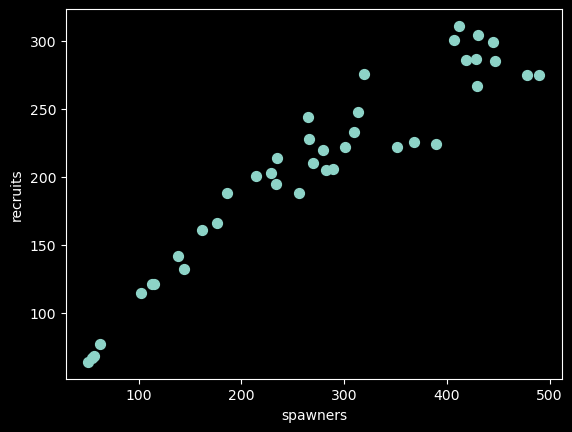

In [3]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

# Parametric approaches

Simple linear regression:

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

$$ \epsilon_i \sim N(0, \sigma) $$

There are three unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

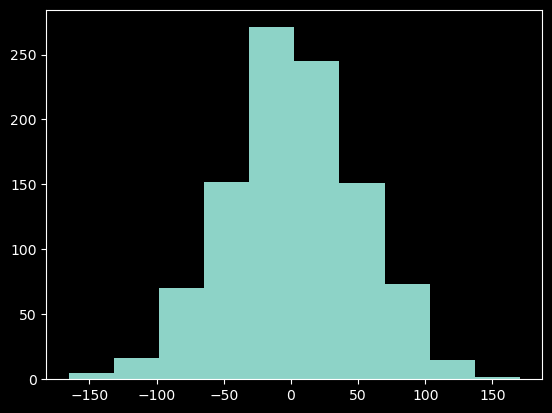

In [8]:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=50)
plt.hist(pm.draw(a_normal_distribution, draws=1000));

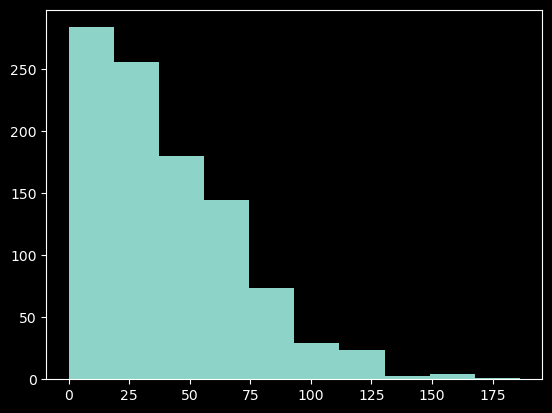

In [9]:
a_half_normal_distribution = pm.HalfNormal.dist(sigma=50)
plt.hist(pm.draw(a_half_normal_distribution, draws=1000));

Extract our predictor and response variables.

In [10]:
x, y = salmon_data[['spawners', 'recruits']].values.T

Construct a model in PyMC3.

In [11]:
with pm.Model() as linear_salmon_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=2)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + β[1] * x
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

Fit the model using Markov chain Monte Carlo (MCMC).

In [12]:
with linear_salmon_model:
    
    linear_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, σ]


Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Examine the posterior distributions of the unknown parameters.

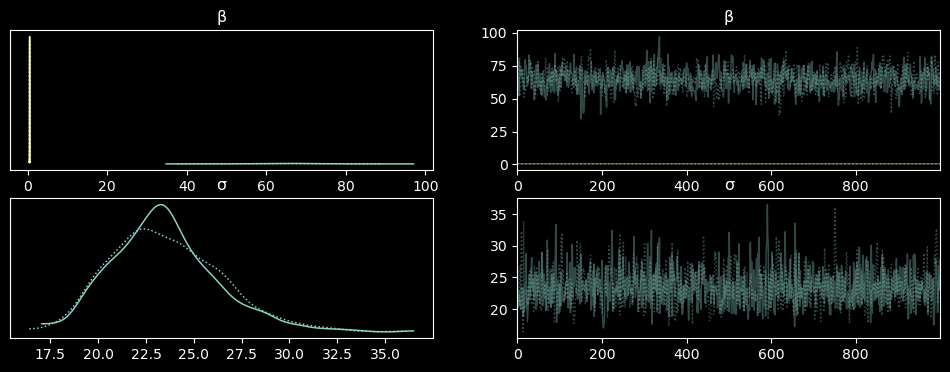

In [13]:
az.plot_trace(linear_trace);

Draw posterior samples of the regression line.

In [21]:
linear_trace.posterior['β'][0][:20].to_numpy()

array([[51.29081966,  0.55255169],
       [54.38688432,  0.56244721],
       [66.08649476,  0.52169419],
       [64.96498536,  0.51828414],
       [52.31810895,  0.57192486],
       [80.77251337,  0.49813272],
       [66.60879701,  0.48929352],
       [66.60879701,  0.48929352],
       [67.94638294,  0.48731874],
       [72.39163342,  0.49897296],
       [72.40753387,  0.4912053 ],
       [72.17383317,  0.49179451],
       [66.26450296,  0.50679148],
       [64.22743115,  0.5290013 ],
       [64.22743115,  0.5290013 ],
       [57.47144853,  0.54112637],
       [61.551865  ,  0.52727899],
       [63.29791018,  0.53940412],
       [79.34904279,  0.46432672],
       [79.34904279,  0.46432672]])

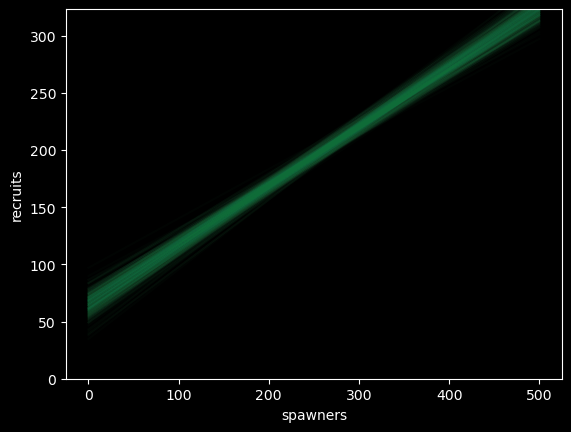

In [25]:
X_pred = np.linspace(0, 500, 100)

ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1 in linear_trace.posterior['β'][0][:400].to_numpy():
    ax.plot(X_pred, b0 + b1*X_pred, alpha=0.03, color='seagreen');

### Quadratic Model

It appears the linear model is a poor fit to the data. Let's make a polynomial (quadratic) model by adding a parameter for $x^2$.

In [26]:
with pm.Model() as quad_salmon_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=3)
    σ = pm.HalfNormal('σ', sigma=50)
    
    μ = β[0] + β[1] * x + β[2] * x**2
    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [27]:
with quad_salmon_model:
    
    quad_trace = pm.sample(1000, tune=2000, cores=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, σ]


Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 12 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


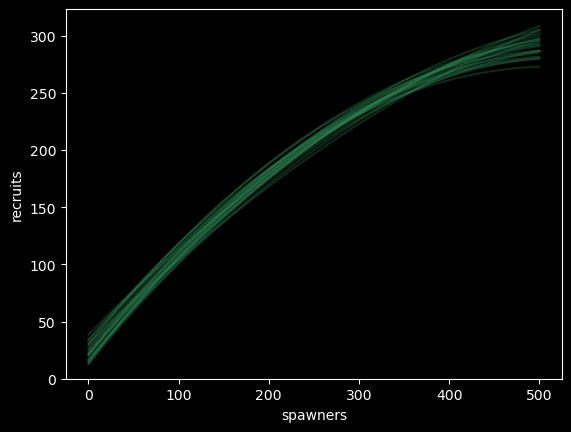

In [30]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1,b2 in quad_trace.posterior['β'][0][:20].to_numpy():
    ax.plot(X_pred, b0 + b1*X_pred + b2*X_pred**2, alpha=0.3, color='seagreen');

![](images/stop.jpg)

Let's go back to the slides ...

---

## Gaussian Process

In [31]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

In [32]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, η, σ]


Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


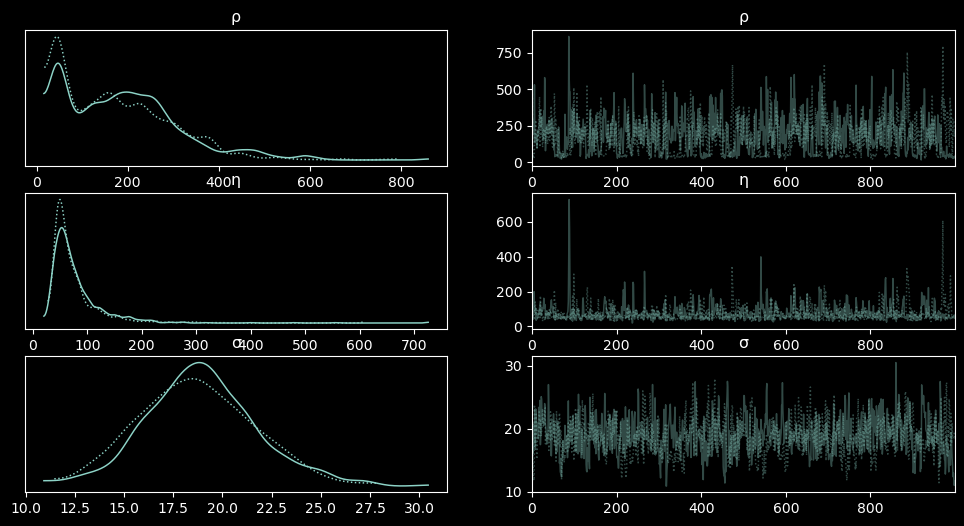

In [33]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [68]:
with gp_salmon_model:
    #salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred'], random_seed=42)

Sampling: [salmon_pred]


Output()

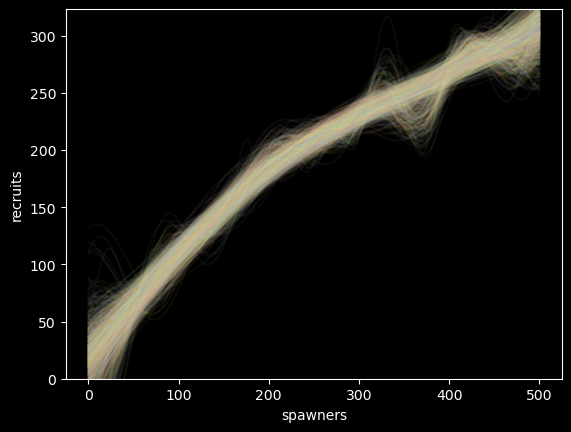

In [69]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_salmon_samples.posterior_predictive['salmon_pred'][0][:]:
    ax.plot(X_pred, x, alpha=0.05);

In [ ]:
# with gp_salmon_model:
#     gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=[salmon_pred], samples=100, random_seed=42)

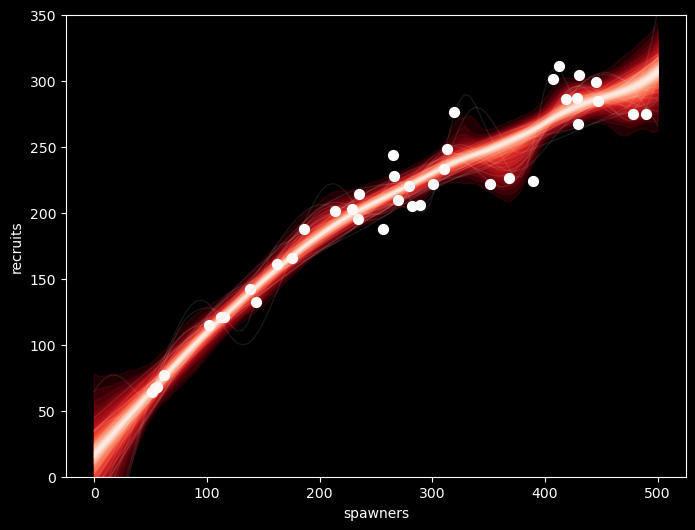

In [70]:
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples.posterior_predictive['salmon_pred'][0], X_pred, palette='Reds_r', fill_alpha=0.3)
salmon_data.plot.scatter(x='spawners', y='recruits', c='w', s=50, ax=ax)
ax.set_ylim(0, 350);

In [72]:
with gp_salmon_model:
    #salmon_pred_noise = recruit_gp.conditional("salmon_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
    gp_salmon_samples_noise = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred_noise'], random_seed=42)

Sampling: [salmon_pred_noise]


Output()

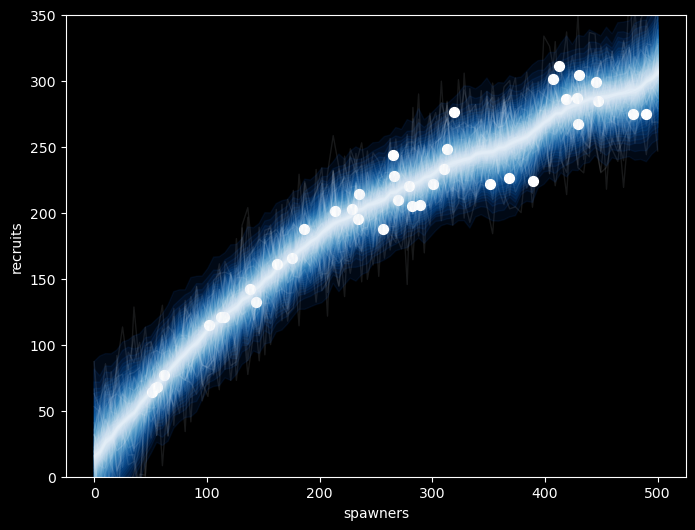

In [73]:
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples_noise.posterior_predictive['salmon_pred_noise'][0], X_pred, palette='Blues_r', fill_alpha=0.2)
salmon_data.plot.scatter(x='spawners', y='recruits', c='w', s=50, ax=ax)
ax.set_ylim(0, 350);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution that covers this range of spawners.

*Hint: you need to add a new `conditional` variable.*

In [ ]:
# Write answer here